# Part 2: Feature Engineering and Modelling

## Introduction

Welcome to the second notebook where we use the scraped Jakarta Apartment Dataset. In this notebook, we will use the cleaned data from our previous notebook to create and evaluate regression models to predict the annual rent price rate of apartments in Jakarta and its surrounding. 

First, we'll analyze the numerical features of our dataset and check if the data has to be scaled and/or if the data has multicolinearity issues. Then, we'll create a baseline model. After that, the baseline model will be evaluated, and further feature engineerings will be done to improve our initial model. Finally, we'll evaluate our models and choose the best model.

## Importing Packages

In [1]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

## Importing the Cleaned Data

In [2]:
df_clean = pd.read_csv('Cleaned Apartment Data.csv')

In [3]:
df_clean = df_clean.drop(['Unnamed: 0', 'Index', 'URL', 'Unit_ID', 'FurnishedNew'], axis = 'columns')

In [4]:
df_clean

,No_Rooms,Locality,Region,Longitude,Latitude,Furnished,Area,AC,Water_Heater,Dining_Set,...,Security,Basketball,Multipurpose_Room,Gym,Jogging,Tennis,Restaurant,Playground,Total_Facilities,AnnualPrice
0,1,Semanggi,Jakarta Selatan,106.819159,-6.226598,1,43.0,1,1,1,...,1,1,1,1,1,1,1,1,23,96000000.0
1,2,Kebon Jeruk,Jakarta Barat,106.756061,-6.192081,0,35.0,1,0,0,...,1,0,1,1,1,0,1,1,19,30000000.0
2,2,Kedoya,Jakarta Barat,106.757651,-6.186415,1,53.0,1,1,1,...,1,0,1,1,1,0,1,1,22,70000000.0
3,2,Pondok Indah,Jakarta Selatan,106.784600,-6.272637,1,85.0,1,1,1,...,1,1,1,1,1,1,1,1,24,576000000.0
4,2,Grogol,Jakarta Barat,106.796056,-6.153652,0,48.0,1,0,0,...,1,0,1,1,0,0,1,1,15,32000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5178,2,Pekayon,Bekasi,106.993400,-6.243400,1,36.0,1,0,1,...,0,0,0,0,0,0,0,1,14,36000000.0
5179,0,BSD City,Tangerang,106.664000,-6.294400,1,32.0,1,1,1,...,1,0,1,1,0,0,0,1,16,60000000.0
5180,2,Setiabudi,Jakarta Selatan,106.829330,-6.216540,1,83.0,1,1,1,...,1,0,1,1,1,0,1,1,21,250000000.0
5181,2,Slipi,Jakarta Pusat,106.801738,-6.202296,1,68.0,1,1,1,...,1,1,1,1,1,1,1,1,24,108000000.0


Last but not least, let's improvise a bit and try to add a 'Is it in Jakarta or not' column. It will be a value of '1' for apartment units in Jakarta, and '0' for apartment units in the satelite region of Jakarta (Bogor, Depok, Tangerang, Bekasi).

In [5]:
Jakcheck = list()
for region in df_clean.Region:
    if 'Jakarta' in region:
        Jakcheck.append(1)
    else:
        Jakcheck.append(0)
        
df_clean['Jakcheck'] = Jakcheck

## Creating Baseline Model

We'll create a baseline model straight away to have a rough model on our dataset before improving anything. If our further feature engineering causes our model to be worse than the baseline model, then we know the feature engineering we perform is not ideal.

In this baseline model, we'll use one-time train test split (no cross validations) and create a simple Linear Regression.

In [6]:
X = df_clean[['No_Rooms', 'Longitude', 'Latitude', 'Furnished', 'Area', 'AC', 'Water_Heater', 
                    'Dining_Set', 'Bed', 'Kitchen', 'Fridge', 
                    'Washing_Machine', 'TV', 'ATM', 'TV_Cable', 'Grocery', 'Internet', 'Swim_Pool', 
                    'Laundry', 'Security', 'Basketball', 'Multipurpose_Room', 'Gym', 
                    'Jogging', 'Tennis','Restaurant', 'Playground', 'Total_Facilities', 'Jakcheck']]
y = df_clean[['AnnualPrice']]

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 23)

Text(0, 0.5, 'predicted value')

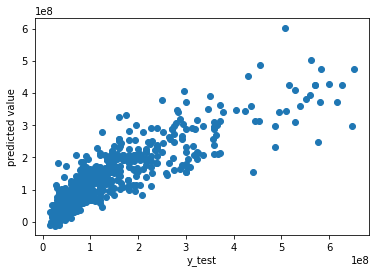

In [8]:
test_val = y_test['AnnualPrice'].to_numpy()
lm = LinearRegression()
lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
plt.scatter(test_val, predictions)
plt.xlabel('y_test')
plt.ylabel('predicted value')

In [9]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(test_val, predictions))
print('MSE:', metrics.mean_squared_error(test_val, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_val, predictions)))
print('R2 Score:', metrics.r2_score(test_val, predictions))

MAE_lm = metrics.mean_absolute_error(test_val, predictions)
MSE_lm = metrics.mean_squared_error(test_val, predictions)
RMSE_lm = np.sqrt(metrics.mean_squared_error(test_val, predictions))
R2_lm = metrics.r2_score(test_val, predictions)

MAE: 29546141.91431634
MSE: 2308342878032167.0
RMSE: 48045217.0151428
R2 Score: 0.7878343259922174


c:\users\grady\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

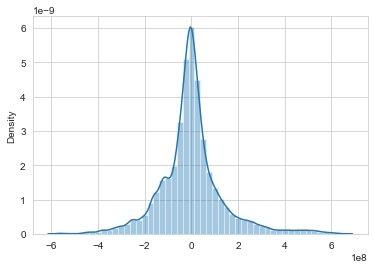

In [10]:
sns.set_style(style = 'whitegrid')

sns.distplot(test_val - predictions, bins = 50)

Our baseline model surprisingly performs quite well. It managed to get a 78% R-squared score, with a relatively normal residual plot. What is R-squared and why should we care? R-squared measures the scatter of our data points around the fitted regression line. A high R-squared score represents that the observed data and fitted value have small differences. According to 'Statistics By Jim', who explained it ellegantly, R-squared is the percentage of the dependent variable variation that a linear model explains.

(Cite: https://statisticsbyjim.com/regression/interpret-r-squared-regression/)

In [11]:
# compute with statsmodels, another way, using formula

import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm

try:
    result = sm.ols(formula="AnnualPrice ~ No_Rooms + Longitude + Latitude + Furnished + Area + AC + Water_Heater + Dining_Set + Bed + Kitchen + Fridge + Washing_Machine + TV + ATM + TV_Cable + Grocery + Internet + Swim_Pool + Laundry + Security + Basketball + Multipurpose_Room + Gym + Jogging + Tennis + Restaurant + Playground + Total_Facilities + Jakcheck", data=df_clean).fit()
    print(result.summary())
except:
    result = sm.ols(formula="AnnualPrice ~ No_Rooms + Longitude + Latitude + Furnished + Area + AC + Water_Heater + Dining_Set + Bed + Kitchen + Fridge + Washing_Machine + TV + ATM + TV_Cable + Grocery + Internet + Swim_Pool + Laundry + Security + Basketball + Multipurpose_Room + Gym + Jogging + Tennis + Restaurant + Playground + Total_Facilities + Jakcheck", data=df_clean).fit()
    print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            AnnualPrice   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     583.5
Date:                Sun, 08 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:08:15   Log-Likelihood:                -98961.
No. Observations:                5183   AIC:                         1.980e+05
Df Residuals:                    5153   BIC:                         1.982e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1.932e+09   1.21e+0

We can get a more detailed result from our regression when we use the statsmodels library. It might seem like a wall of text, but don't worry - we'll look at what we can derive from this result.

- R-Squared and Adjusted R-Squared are fairly similar. Adjusted R-Squared is always lower than R-Squared because it penalizes the model if the model uses features which are not significant. So, for example, if we add another insignificant feature to the model, the Adjusted R-Squared will decrease, while R-Squared will mostly stay the same or increase. If the model's Adjusted R-Squared is way below the R-Squared, it means there are a lot of insignificant features. Fortunately for us, that doesn't seem to be the case.


- We have a 0 p-value of the F-statistic. In plain English, the F-statistic tests whether there is a significant linear relation between our features (independent variables) and our target (dependent variable). The null hypothesis is that there is no relation ebtween our features and our target, meaning the regression model arrives at such result by chance. When the p-value is 0 (or below alpha, which is usually 0.05), we can reject the null hypothesis, and assure ourselves that our model fits the data well because indeed - there are linear relations between our features and our target.


- In the central table, there is a list of our features. The column 'coefficient' tells us what each feature's coefficients are. Remember that these coefficients explain the relation of our feature to our target variable. Aside from thee 'coefficient' column, we also have 't' column. This 't' column is the t-statistic of each feature in yet another statistical test. The null hypothesis of this t-test is that the coefficient of our feature is 0 (which means our feature does not have a significant relationship to our target variable). The alternate hypothesis is that the coefficient of our feature is not 0. A p-value of less than alpha (usually 0.05) means that we can reject the null hypothesis. Let's look at the 'Area' feature for example. The p-value for the 'Area' feature is 0, which means we are sure that the coefficient of 'Area' feature is indeed 2.086e+06, and it has a significant relationship with our target variable. However, if we look at the Dining_Set feature, its p-value is more than 0.9. We can't reject the null hypothesis on that. Thus, we can say that we are unsure that the presence of dining set at an apartment has a significant relationship on its annual rent price.


- In the lower part of the summary, we can see that our model has a skew around 1.5. This means the residual of our model, which seems to be normal, isn't actually centered and it's a bit skewed. Normality of the residuals is an assumption of running a linear model. So, if the residuals are normal, it means that our assumption is valid and model inference (confidence intervals, model predictions) should also be valid. Don't worry - this doesn't mean that our model is entirely invalid - we still have a lot of room for improvement, and the skew is still in single digit.


- The second point of the note tells us that it suspects our model to have multicolinearity issue. What is that? We'll discuss it further in the next part.

Just for curiosity's sake, let's create a regression model based on only the variables which we think would matter the most.

In [12]:
# compute with statsmodels, another way, using formula

import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm

result_2 = sm.ols(formula="AnnualPrice ~ No_Rooms + Longitude + Latitude + Furnished + Total_Facilities + Area + Jakcheck", data=df_clean).fit()
print(result_2.summary())

                            OLS Regression Results                            
Dep. Variable:            AnnualPrice   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     2278.
Date:                Sun, 08 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:08:15   Log-Likelihood:                -99087.
No. Observations:                5183   AIC:                         1.982e+05
Df Residuals:                    5175   BIC:                         1.982e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -1.171e+08   1.15e+09  

In terms of accuracy (in which we use the R-squared metric), it goes down about 2 percent, but all of our variables have good p-value, except for Longitude and Intercept, surprisingly.

## Checking for Correlation

Let's discuss briefly the danger of multicolinearity. Multicolinearity is an issue when multiple independent variables are correlated to each other. Why is this an issue? 

Regression analysis requires us to isolate the relationship between each independent variable and dependent variable. For example, in a very simple example, let's imagine a regression between two variables, x1 and x2.

Y = 5X1 - 3X2

How we interpret the '5' coefficient of X1 is the following:

When everything else stays constant, an increment of 1 unit in X1 causes an increment of 5 unit of Y variable. We often disregard the first phrase that says 'when everything else stays constant'. If X1 is not correlated to X2, then an increment of 1 unit of X1 causes the 'Y' variable to increase by 5, because the X2 doesn't change at all. This is good - because the coefficient of '5' clearly explains the relationship between X1 and Y. 

If X1 is highly correlated to X2, then an increment of 1 unit of X1 will also cause X2 to change. This will make the 'Y' variable's movement not equal to 5 (the coefficient of X1). Therefore, the coefficient of '5' does not explain the relationship between X1 and Y.

When we have multicolinearity, we don't have confidence in the coefficients of each independent variables. We don't know if those coefficients show the true relationship of those variables and the predicted variable. And thus, we can't really be sure on which independent variables are most affecting the target/predicted variable. 

This causes problem when we want to predict the Y model when we put aritrary values of X1 and X2. For example, wan X1 of 4 and X2 of 2 will result in Y = 5*4 - 3*2 = 20 - 6 = 14. Then, when we change X1 to 6, our predicted variable should increase by 10 units. This is the case if X1 and X2 are independent. However, if X1 and X2 are correlated, when we change X1 to 6, X2 will also change. This will result in our prediction not representing the accurate reality of the problem.

However, multicolinearity might not be a problem if:
- we have small to moderate multicolinearity. 
- only a small portion of our variables are having multicolinearity issues with one another. If we have 10 independent variables, and only 3 of them are correlated to each other, then the multicolinearity only persits in those 3 variables - the other seven variables are fine
- our goal is to only create prediction. If we don't really need to analyze the variables at the end of our project, and we just care about predictions, we don't really need to make a fuss about multicolinearity

So here's what we're gonna do on this project.

Referring to the problem statement, we would like to have a clear regression model which can explain relationships between independent variables and the tarrget variable if possible. However, if we can't avoid multicolinearity, we'll look over it and just focus on our predictions.

<AxesSubplot:>

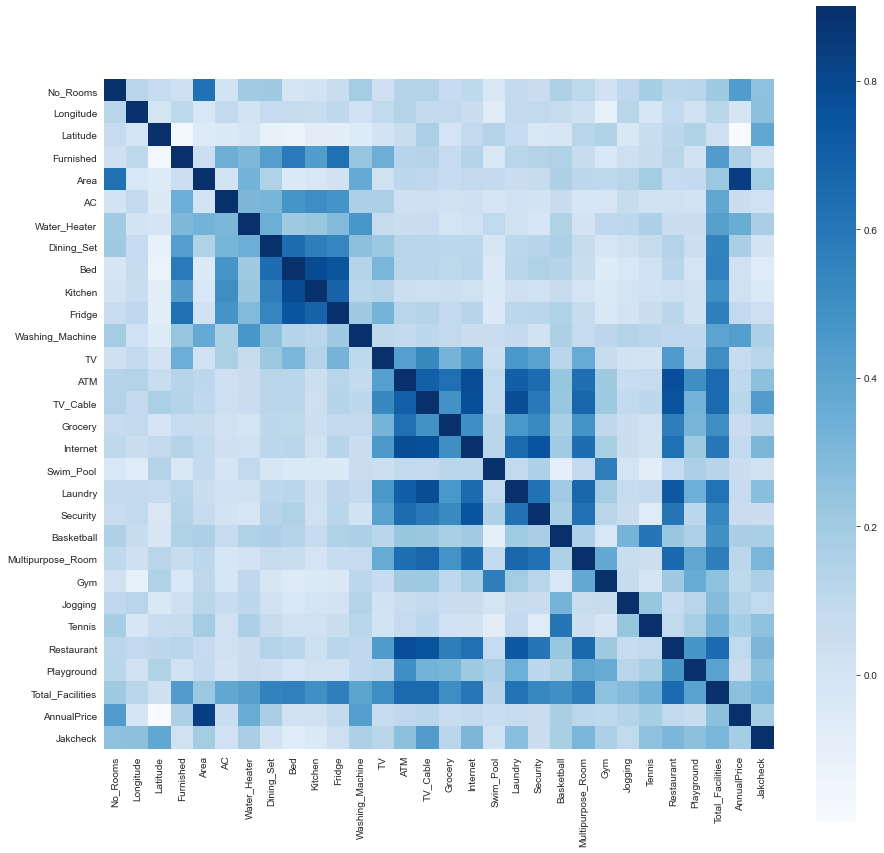

In [13]:
corr = df_clean.corr()
plt.subplots(figsize=(15,15))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

Using seaborn heatmap, we can visualize which of our variables have high correlation with each other. After looking at the heatmap above, there are some insights we can derive. First, our dependent variable, 'AnnualPrice', has a high correlation with the columns 'No_Rooms', 'Area' and surprisingly, the existenec of 'Water_Heater' and 'Washing_Machine'. 

Second, there are four 'groups' of facility variables which are highly correlated to each other. These groups are:
- The first group: 'AC', 'Water_Heater', 'Dining_Set', 'Bed', 'Kitchen', 'Fridge', as well as 'Furnished' variable
- The second group: 'TV', 'ATM', 'TV_Cable', 'Grocery', 'Internet', 'Laundry', 'Security', 'Multipurpose_Room', 'Restaurant' and 'Playground'
- The third group: 'Swim_Pool', 'Gym', 
- The fourth group comprises of: 'Tennis', 'Jogging', 'Basketball'

For example, an apartment unit that has 'Water_Heater' most likely also has 'Dining_Set', 'Electricity', 'Bed', and the facilities in the first group. And another apartment unit which has 'Swim_Pool' most likely also has 'Gym'. Surprisingly, the facility 'Washing_Machine' stands on its own ground for the most part - and only correlates highly to 'Water_Heater' and 'AnnualPrice'. 

A strange thing to note is that 'No_Rooms' have high correlation with 'Area', but don't their p-values are equal to 0 in the four-variable regression? This might seem weird, but we'll get to the bottom of this in a few more steps.

What should we do now? We can create four groups of facilities based on their correlation map above. Then, sum the '0s' and '1s' of the feature in the same group. Use these four sums as numerical variables, and discard all other singular columns of facilities and 'Total_Facilities'. 


In [14]:
Group1 = df_clean.AC + df_clean.Water_Heater + df_clean.Dining_Set + df_clean.Bed + df_clean.Kitchen + df_clean.Fridge + df_clean.Furnished
Group2 = df_clean.TV + df_clean.ATM + df_clean.TV_Cable + df_clean.Grocery + df_clean.Internet + df_clean.Laundry + df_clean.Security + df_clean.Multipurpose_Room + df_clean.Restaurant + df_clean.Playground
Group3 = df_clean.Swim_Pool + df_clean.Gym
Group4 = df_clean.Tennis + df_clean.Jogging + df_clean.Basketball

df_clean['Group1'] = Group1
df_clean['Group2'] = Group2
df_clean['Group3'] = Group3
df_clean['Group4'] = Group4

We're going to do another linear regression but we replace the grouped units with Group1, Group2, Group3, and Group4. 

In [15]:
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm

result_grouped = sm.ols(formula="AnnualPrice ~ No_Rooms + Longitude + Latitude + Group1 + Group2 + Group3 + Group4 + Area", data=df_clean).fit()
print(result_grouped.summary())

                            OLS Regression Results                            
Dep. Variable:            AnnualPrice   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     1877.
Date:                Sun, 08 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:08:15   Log-Likelihood:                -99203.
No. Observations:                5183   AIC:                         1.984e+05
Df Residuals:                    5174   BIC:                         1.985e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.326e+09   1.15e+09     -3.754      0.0

On the bright side, all features' p-values are below 0.05, which means that all of our features are significant. However, our accuracy didn't improve. So we now have 3 models:
- A model with 76% R squared score with lots of features having p-value above 0.05
- A model with 74.7% R squared score with one feature & the intercept having p-value above 0.05 
- A model with 74.2% R squared score with no features having p-value above 0.05

We'll try to scale the numerical data and see if we can do further regularizations with linear regression and obtain a better result.

## Feature Scaling

Most of the times, numerical features in our model comes in different magnitudes and distribution. For example, a simple model predicting the weight of a shopping bag has number of items bought and money spent as its predictor. If we add one more item to our shopping bag, it would definitely affect the weight of the whole bag immediately. However, if we add one more rupiah to the amount of money spent (or even hundreds of rupiah), chances are the weight of the bag does not change (as one item in most grocery shops costs more than one thousand rupiah). However, our model won't be able to recognize the context of these predictors - it just views them as floats/integers. 

Machine learning models which uses distance such as K-Nearest Neighbors, Gradient Descent, etc, benefited heavily from feature scaling.Since we're doing l1 and l2 regularization by creating Lasso, Ridge, and ElasticNet regression model, it's best to scale our data first before doing any regularization.

Let's begin this step by visualizing (again) the distribution of our numerical features - 'Area', 'Longitude', and 'Latitude'.

<AxesSubplot:xlabel='Area', ylabel='Density'>

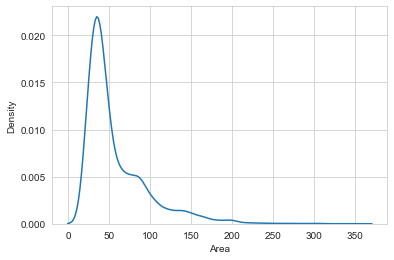

In [16]:
sns.kdeplot(df_clean.Area)

<AxesSubplot:xlabel='Longitude', ylabel='Density'>

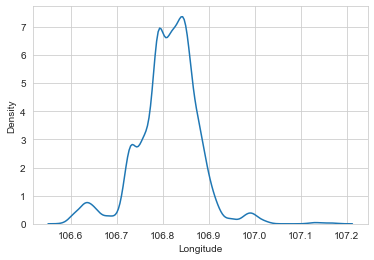

In [17]:
sns.kdeplot(df_clean.Longitude)

<AxesSubplot:xlabel='Latitude', ylabel='Density'>

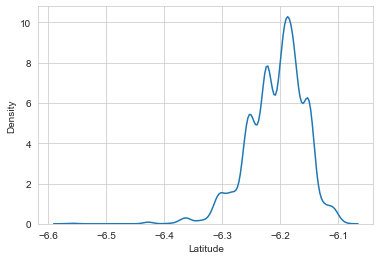

In [18]:
sns.kdeplot(df_clean.Latitude)

In [19]:
def scale(data, add=0):
    boxcox = boxcox1p(data + add, boxcox_normmax(data + add + 1))
    result = (boxcox-min(boxcox))/(max(boxcox)-min(boxcox))
    return(result)

In [20]:
Scaled_Lat = scale(df_clean['Latitude'], add = 7)
Scaled_Lon = scale(df_clean['Longitude'], add = 0)
Scaled_Area = scale(df_clean['Area'], add = 0)
Scaled_Norooms = scale(df_clean['No_Rooms'], add = 1)

df_clean['Scaled_Lat'] = Scaled_Lat
df_clean['Scaled_Lon'] = Scaled_Lon
df_clean['Scaled_Area'] = Scaled_Area
df_clean['Scaled_Norooms'] = Scaled_Norooms

As an example of how these scaling work, let's see the distribution of Scaled_Area

<AxesSubplot:xlabel='Area', ylabel='Density'>

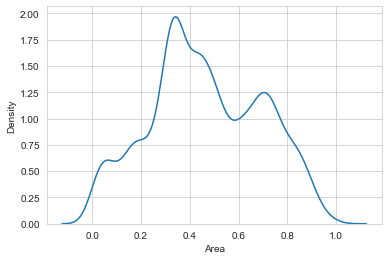

In [21]:
sns.kdeplot(Scaled_Area)

In [22]:
df_clean.columns

Index(['No_Rooms', 'Locality', 'Region', 'Longitude', 'Latitude', 'Furnished',
       'Area', 'AC', 'Water_Heater', 'Dining_Set', 'Bed', 'Kitchen', 'Fridge',
       'Washing_Machine', 'TV', 'ATM', 'TV_Cable', 'Grocery', 'Internet',
       'Swim_Pool', 'Laundry', 'Security', 'Basketball', 'Multipurpose_Room',
       'Gym', 'Jogging', 'Tennis', 'Restaurant', 'Playground',
       'Total_Facilities', 'AnnualPrice', 'Jakcheck', 'Group1', 'Group2',
       'Group3', 'Group4', 'Scaled_Lat', 'Scaled_Lon', 'Scaled_Area',
       'Scaled_Norooms'],
      dtype='object')

In [23]:
lm_elasticnet = ElasticNet()

lm_lasso = Lasso()
lm_ridge = Ridge()

In [24]:
#ElasticNet Evaluation
lm_elasticnet.fit(X_train, y_train)
predictions = lm_elasticnet.predict(X_test)
test_val = y_test.AnnualPrice.to_numpy()
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(test_val, predictions))
print('MSE:', metrics.mean_squared_error(test_val, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_val, predictions)))
print('R2 Score:', metrics.r2_score(test_val, predictions))

MAE: 30395800.309556354
MSE: 2581438429281655.0
RMSE: 50807857.9481723
R2 Score: 0.7627334182151332


In [25]:
#Lasso Evaluation
lm_lasso.fit(X_train, y_train)
predictions = lm_lasso.predict(X_test)
test_val = y_test.AnnualPrice.to_numpy()
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(test_val, predictions))
print('MSE:', metrics.mean_squared_error(test_val, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_val, predictions)))
print('R2 Score:', metrics.r2_score(test_val, predictions))

MAE: 29546130.896945063
MSE: 2308342478850902.0
RMSE: 48045212.86091781
R2 Score: 0.7878343626819843


c:\users\grady\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1098481875277824e+16, tolerance: 3864468980189401.5
  model = cd_fast.enet_coordinate_descent(


In [26]:
#Ridge Evaluation
lm_ridge.fit(X_train, y_train)
predictions = lm_ridge.predict(X_test)
test_val = y_test.AnnualPrice.to_numpy()
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(test_val, predictions))
print('MSE:', metrics.mean_squared_error(test_val, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_val, predictions)))
print('R2 Score:', metrics.r2_score(test_val, predictions))

MAE: 29280066.900174823
MSE: 2302552286210119.0
RMSE: 47984917.27835028
R2 Score: 0.7883665540370719


It seems that our ElasticNet, Lasso, and Ridge regression does not improve our model that much. Let's try another algorithm called Extreme Gradient Boosting, or in short, XGBoost.

## XGBoost

XGBoost is a gradient boosted decision trees algorithm which has dominated Kaggle in recent years. Unlike Linear Regression, it does not have to be scaled, and it can handle multicolinearity better since by its nature, decision trees are immune to multicolinearity. However, it will not yield an outcome which can be interpreted as clear as Linear Regression. It doesn't have any explicit coefficient which can further be tested with t-test and calculate it's p-value.

XGBoost also has a feature selector algorithm built into scikit-learn, in which it will try out multiple combinations of features, and tell us which features are the most important (as well as which features are not important).

In [27]:
X = df_clean[['No_Rooms', 'Longitude', 'Latitude', 'Furnished', 'Area',
             'AC', 'Water_Heater', 'Dining_Set', 'Bed', 'Kitchen',
             'Fridge', 'Washing_Machine', 'TV', 'ATM', 'TV_Cable', 'Grocery', 'Internet', 'Swim_Pool', 
              'Laundry', 'Security','Basketball', 'Multipurpose_Room', 'Gym', 'Jogging', 'Tennis',
              'Restaurant', 'Playground', 'Jakcheck']]
y = df_clean[['AnnualPrice']]

In [28]:
train_labels = list()
for _ in y.AnnualPrice:
    train_labels.append(_)

In [29]:
kf = KFold(n_splits=12, random_state=42, shuffle=True)
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_r2(model, X=X, y=y):
    r2 = cross_val_score(model, X, y, scoring="r2", cv=kf)
    return (r2)

In [30]:
xgboost = XGBRegressor()

In [31]:
score = cv_r2(xgboost, X, y)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))

xgboost: 0.8988 (0.0197)


Without any scaling and/or multicolinearity testing, we achieved an average R-squared score of 89.83 percent. This is much better than what we have previously with linear regression models. Next, we'll try to use RFECV to select our features.

## Feature Selection for XGBoost

In [32]:
from sklearn.feature_selection import RFECV
from xgboost.sklearn import XGBRegressor
import sklearn.metrics
from sklearn.metrics import mean_absolute_error

estimator = XGBRegressor()
selector = RFECV(estimator, step=1, min_features_to_select=1, cv=10, scoring='neg_mean_absolute_error')
selector = selector.fit(X, train_labels)

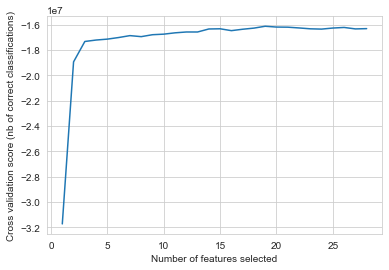

In [33]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [34]:
selector

RFECV(cv=10,
      estimator=XGBRegressor(base_score=None, booster=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, gamma=None, gpu_id=None,
                             importance_type='gain',
                             interaction_constraints=None, learning_rate=None,
                             max_delta_step=None, max_depth=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, n_estimators=100,
                             n_jobs=None, num_parallel_tree=None,
                             random_state=None, reg_alpha=None, reg_lambda=None,
                             scale_pos_weight=None, subsample=None,
                             tree_method=None, validate_parameters=None,
                             verbosity=None),
      scoring='neg_mean_absolute_error')

In [35]:
selector.support_

array([ True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True, False, False, False,  True, False,  True,
       False, False,  True,  True, False,  True,  True,  True,  True,
        True])

In [36]:
selector.ranking_

array([ 1,  1,  1,  1,  1,  1,  1,  3,  5,  1,  1,  1,  2,  4,  7,  1, 10,
        1,  9,  8,  1,  1,  6,  1,  1,  1,  1,  1])

In [37]:
selector.estimator_.feature_importances_ 

array([0.01804168, 0.04023799, 0.11332636, 0.01674266, 0.37837452,
       0.01021922, 0.01946996, 0.01876591, 0.01940808, 0.02224082,
       0.009871  , 0.07845438, 0.0373201 , 0.04641338, 0.02395476,
       0.02572067, 0.03711102, 0.05364774, 0.03067974], dtype=float32)

In [38]:
X.columns

Index(['No_Rooms', 'Longitude', 'Latitude', 'Furnished', 'Area', 'AC',
       'Water_Heater', 'Dining_Set', 'Bed', 'Kitchen', 'Fridge',
       'Washing_Machine', 'TV', 'ATM', 'TV_Cable', 'Grocery', 'Internet',
       'Swim_Pool', 'Laundry', 'Security', 'Basketball', 'Multipurpose_Room',
       'Gym', 'Jogging', 'Tennis', 'Restaurant', 'Playground', 'Jakcheck'],
      dtype='object')

In [39]:
fs = {'Features': X.columns,
        'Selection Status': selector.support_
        }

feature_selection_all = pd.DataFrame(fs, columns = ['Features', 'Selection Status'])
feature_selection_all

,Features,Selection Status
0,No_Rooms,True
1,Longitude,True
2,Latitude,True
3,Furnished,True
4,Area,True
5,AC,True
6,Water_Heater,True
7,Dining_Set,False
8,Bed,False
9,Kitchen,True


In [40]:
selected_features = feature_selection_all[feature_selection_all['Selection Status'] == True]

In [41]:
selected_features['Importance'] = selector.estimator_.feature_importances_ 

<ipython-input-41-f64bec585cc7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features['Importance'] = selector.estimator_.feature_importances_


In [42]:
selected_features = selected_features.sort_values(by=['Importance'], ascending=False)

In [43]:
selected_features

,Features,Selection Status,Importance
4,Area,True,0.378375
2,Latitude,True,0.113326
17,Swim_Pool,True,0.078454
26,Playground,True,0.053648
21,Multipurpose_Room,True,0.046413
1,Longitude,True,0.040238
20,Basketball,True,0.037320
25,Restaurant,True,0.037111
27,Jakcheck,True,0.030680
24,Tennis,True,0.025721


In [44]:
len(selected_features.Features)

19

After performing feature selection, we see that we end up with 19 selected features. However, upon seeing the selected features and its importance, I think it's a good idea to remove 'AC' and 'Grocery' as it is the bottom two features. Most apartments have AC units and some kind of grocery shops (Indomaret / Alfamart) near its vicinity anyway. Furthermore, it's better to try building a model with less number of features as it could be a good tactic to avoid overfitting. 

From the table above, we get the following takeaways:
- Area of apartment unit is the most important feature. This makes sense as it's a rule of thumb in most property cases: the more area it covers, the more expensive the property is.
- Location also plays important role in determining its price. It seems that Latitude plays a bigger role than Longitude, however both are within the top 10 of the ranked list. Also, our added feature to check whether the unit is in Jakarta or in its satelite regions seem to be pretty useful too.
- The facilities that affects the annual price the most are the 'luxurious' facilities, such as multipurpose room, swimming pool, and tennis field. These facilities are almost always not present in lower-priced apartments, so they can be a good predictor towards the annual rent price target variable. 

In [45]:
selected_features = selected_features[selected_features["Features"]!="AC"]
selected_features = selected_features[selected_features["Features"]!="Grocery"]
selected_features = selected_features.drop(['Selection Status'], axis = 'columns')
selected_features.to_csv('selected features.csv')

In [46]:
selected_features

,Features,Importance
4,Area,0.378375
2,Latitude,0.113326
17,Swim_Pool,0.078454
26,Playground,0.053648
21,Multipurpose_Room,0.046413
1,Longitude,0.040238
20,Basketball,0.037320
25,Restaurant,0.037111
27,Jakcheck,0.030680
24,Tennis,0.025721


In [47]:
X_s = X[['Area', 'Latitude', 'Longitude', 'Jakcheck', 'Multipurpose_Room', 'Playground', 'Basketball', 'Swim_Pool', 'Jogging',
        'Restaurant', 'Tennis', 'Washing_Machine', 'Fridge', 'Furnished', 'Water_Heater', 'Kitchen', 'No_Rooms']]
y = y

We'll only use these feature columns moving forward.

In [48]:
score = cv_r2(xgboost, X=X_s, y = y.AnnualPrice)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))

xgboost: 0.8959 (0.0226)


## Hyperparameter Tuning for XGBoost

Next, we're going to tune the parameters for XGBoost to see if we can still further improve our model. We can also do a log-transformation on the AnnualPrice during training before transforming it back to its original scale. We'll see if this technique makes the model perform better (as our previous predictions suffer a bit of a heteroscedasticity at the larger values). Thus, there are 4 models to be compared:

1. A baseline XGBoost model
2. A baseline XGBoost model with log-transformation
3. A tuned XGBoost model
4. A tuned XGBoost model with log-transformation.

However, there's a twist - we're not exactly looking at how good a model's prediction is solely. We want a model that does not suffer from overfitting. To assure that, our model will predict both the train and test set. We'll evaluate both predictions and evaluate how different are the metrics that we get from training set's predictions and test set's predictions.

If there is a huge discrepancy between training prediction metrics and testing prediction metrics, that model is most likely overfitting. The metrics that we use for this evaluation will be RMSE and R squared.

Base XGBoost Model:

Text(0, 0.5, 'predicted value')

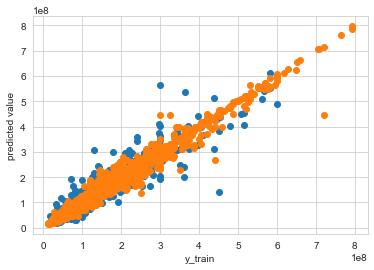

In [97]:
##Tran Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size = 0.2, random_state = 123)

train_labels = list()
for _ in y_train.AnnualPrice:
    train_labels.append(_)
    
test_labels = list()
for _ in y_test.AnnualPrice:
    test_labels.append(_)

XGBoost_Base = XGBRegressor()
XGBoost_Base.fit(X_train, y_train)

predict_base = XGBoost_Base.predict(X_test)
test_val = y_test.to_numpy()
plt.scatter(test_val, predict_base)
plt.xlabel('y_test')
plt.ylabel('predicted value')

train_base = XGBoost_Base.predict(X_train)
train_val = y_train.to_numpy()
plt.scatter(train_val, train_base)
plt.xlabel('y_train')
plt.ylabel('predicted value')

In [98]:
from sklearn import metrics
print('RMSE (Test):', np.sqrt(metrics.mean_squared_error(test_val, predict_base)))
print('R2 Score (Test):', metrics.r2_score(test_val, predict_base))

print('RMSE (Train):', np.sqrt(metrics.mean_squared_error(train_val, train_base)))
print('R2 Score (Train):', metrics.r2_score(train_val, train_base))

RMSE (Test): 29543181.676278032
R2 Score (Test): 0.9062649666110133
RMSE (Train): 13943312.990665685
R2 Score (Train): 0.979983569365708


As we can see, the test RMSE is more than double the train RMSE. The R-squared of the training set is subjectively much higher than the R-squared of the test set, which implies overfitting.

Log Transform the Target Variable

Text(0, 0.5, 'predicted value')

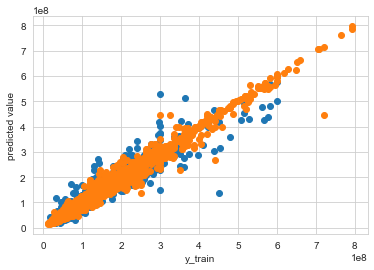

In [99]:
##Tran Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size = 0.2, random_state = 123)

train_labels = list()
for _ in y_train.AnnualPrice:
    train_labels.append(_)
    
test_labels = list()
for _ in y_test.AnnualPrice:
    test_labels.append(_)

XGBoost_Base = XGBRegressor()
XGBoost_Base.fit(X_train, np.log1p(y_train))

predict_base_log = np.expm1(XGBoost_Base.predict(X_test))
test_val = y_test.to_numpy()
plt.scatter(test_val, true_pred)
plt.xlabel('y_test')
plt.ylabel('predicted value')

train_base_log = np.expm1(XGBoost_Base.predict(X_train))
train_val = y_train.to_numpy()
plt.scatter(train_val, train_base)
plt.xlabel('y_train')
plt.ylabel('predicted value')

In [100]:
from sklearn import metrics
print('RMSE (Test):', np.sqrt(metrics.mean_squared_error(test_val, predict_base_log)))
print('R2 Score (Test):', metrics.r2_score(test_val, predict_base))

print('RMSE (Train):', np.sqrt(metrics.mean_squared_error(train_val, train_base_log)))
print('R2 Score (Train):', metrics.r2_score(train_val, train_base))

RMSE (Test): 29414065.11064599
R2 Score (Test): 0.9062649666110133
RMSE (Train): 16642825.566310175
R2 Score (Train): 0.979983569365708


This seems to be the case as well for the base model with log transformation. It seems that performing log transformation does not help our model a lot - in terms of increasing accuracy and reducing overfitting.

Now, let's try to do some hyperparameter tuning with our XGBoost Regressor.

In [173]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


xgb = XGBRegressor()
params = {
        'min_child_weight': [5, 6, 8, 10],
        'gamma': [3, 5, 7],
        'subsample': [0.1, 0.4, 0.6],
        'colsample_bytree': [0.1, 0.4, 0.6],
        'max_depth': [7, 9, 10, 12, 15],
        'eta' : [0.1],
        'learning_rate' : [0.04, 0.05, 0.06, 0.075],
        'n_estimators' : [100, 125]
        }

skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 100)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=150, 
                                   scoring='neg_root_mean_squared_error', n_jobs=-1, cv=skf.split(X_s,y.AnnualPrice), verbose=2, random_state=1001 )
random_search.fit(X_s, y.AnnualPrice)

print(random_search.best_score_)
print(random_search.best_params_)

c:\users\grady\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 150 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.3min finished


-29910279.177531254
{'subsample': 0.6, 'n_estimators': 125, 'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.05, 'gamma': 3, 'eta': 0.1, 'colsample_bytree': 0.6}


From a glance, our RMSE on testing set isn't that different from the RMSE of previous models. However, let's see if this model also suffers from overfitting.

RMSE (Test): 29377053.629938092
R2 Score (Test): 0.9073161895725046
RMSE (Train): 22395350.969635192
R2 Score (Train): 0.9483618791971712


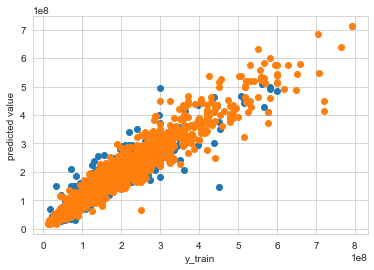

In [246]:
##Tran Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size = 0.2, random_state = 123)

train_labels = list()
for _ in y_train.AnnualPrice:
    train_labels.append(_)
    
test_labels = list()
for _ in y_test.AnnualPrice:
    test_labels.append(_)

tuned_xgb = XGBRegressor(subsample=0.5, n_estimators = 120, min_child_weight = 7, max_depth = 12,
                         learning_rate = 0.05, gamma = 3, eta = 0.1, colsample_bytree = 0.6)
tuned_xgb.fit(X_train, y_train)

prediction = tuned_xgb.predict(X_test)
test_val = y_test.to_numpy()
plt.scatter(test_val, prediction)
plt.xlabel('y_test')
plt.ylabel('predicted value')

train_base = tuned_xgb.predict(X_train)
train_val = y_train.to_numpy()
plt.scatter(train_val, train_base)
plt.xlabel('y_train')
plt.ylabel('predicted value')

from sklearn import metrics
print('RMSE (Test):', np.sqrt(metrics.mean_squared_error(test_val, prediction)))
print('R2 Score (Test):', metrics.r2_score(test_val, prediction))

print('RMSE (Train):', np.sqrt(metrics.mean_squared_error(train_val, train_base)))
print('R2 Score (Train):', metrics.r2_score(train_val, train_base))

Although our accuracy on the test set does not improve that much, the discrepancy between test and training set lowers. Let's settle on this model and check for other random states.

RMSE (Test): 29215004.78179571
R2 Score (Test): 0.9079581496960986
RMSE (Train): 22523739.020251747
R2 Score (Train): 0.9478219497897742


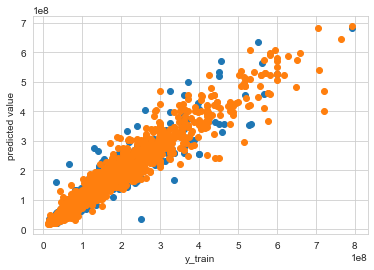

In [255]:
##Tran Test Split
import random
from random import randint
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size = 0.2, random_state = randint(0,1000))

train_labels = list()
for _ in y_train.AnnualPrice:
    train_labels.append(_)
    
test_labels = list()
for _ in y_test.AnnualPrice:
    test_labels.append(_)

tuned_xgb = XGBRegressor(subsample=0.5, n_estimators = 120, min_child_weight = 7, max_depth = 12,
                         learning_rate = 0.05, gamma = 3, eta = 0.1, colsample_bytree = 0.6)
tuned_xgb.fit(X_train, y_train)

prediction = tuned_xgb.predict(X_test)
test_val = y_test.to_numpy()
plt.scatter(test_val, prediction)
plt.xlabel('y_test')
plt.ylabel('predicted value')

train_base = tuned_xgb.predict(X_train)
train_val = y_train.to_numpy()
plt.scatter(train_val, train_base)
plt.xlabel('y_train')
plt.ylabel('predicted value')

from sklearn import metrics
print('RMSE (Test):', np.sqrt(metrics.mean_squared_error(test_val, prediction)))
print('R2 Score (Test):', metrics.r2_score(test_val, prediction))

print('RMSE (Train):', np.sqrt(metrics.mean_squared_error(train_val, train_base)))
print('R2 Score (Train):', metrics.r2_score(train_val, train_base))

In [257]:
final_model = XGBRegressor(subsample=0.5, n_estimators = 120, min_child_weight = 7, max_depth = 12,
                         learning_rate = 0.05, gamma = 3, eta = 0.1, colsample_bytree = 0.6)
final_model.fit(X_s, y.AnnualPrice)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eta=0.1, gamma=3,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=12,
             min_child_weight=7, missing=nan, monotone_constraints='()',
             n_estimators=120, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [258]:
import pickle

xgboost_tuned = pickle.dump(final_model, open('xgboost_tuned.pickle.dat', 'wb'))

import joblib

xgboost_tuned = joblib.dump(final_model, "xgboost_tuned.joblib.dat")


In [259]:
X_s.columns

Index(['Area', 'Latitude', 'Longitude', 'Jakcheck', 'Multipurpose_Room',
       'Playground', 'Basketball', 'Swim_Pool', 'Jogging', 'Restaurant',
       'Tennis', 'Washing_Machine', 'Fridge', 'Furnished', 'Water_Heater',
       'Kitchen', 'No_Rooms'],
      dtype='object')

In [260]:
final_dataset = X_s
final_dataset['AnnualPrice'] = y.AnnualPrice
final_dataset = final_dataset.reset_index(drop = True)
final_dataset.to_csv('Final Dataset.csv')

<ipython-input-260-378486d70d23>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset['AnnualPrice'] = y.AnnualPrice


In [268]:
# tuned_xgb = XGBRegressor(subsample=0.4, n_estimators=200, min_child_weight=11, max_depth=12, learning_rate=0.05, gamma=3, eta=0.05,
#                         colsample_bytree=0.4)
tuned_xgb.fit(X_train, y_train)
tuned_pred = tuned_xgb.predict(X_test)
train_pred = tuned_xgb.predict(X_train)
print(np.sqrt(metrics.mean_squared_error(test_val, tuned_pred)))
print(metrics.r2_score(test_val, tuned_pred))
print(np.sqrt(metrics.mean_squared_error(y_train.to_numpy(), train_pred)))
print(metrics.r2_score(y_train.to_numpy(), train_pred))

29215004.78179571
0.9079581496960986
22523739.020251747
0.9478219497897742


In [ ]:
#tuned_xgb = XGBRegressor(subsample=0.8, n_estimators = 100, min_child_weight = 1, max_depth = 12,
                         #learning_rate = 0.1, gamma = 7, eta = 0.05, colsample_bytree = 1.0)

In [ ]:
{'subsample': 0.4, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.05, 'gamma': 3, 'eta': 0.1, 'colsample_bytree': 0.4}